# CS 171 Final Project — Model Construction Notebook

This notebook:

1. Loads the pre-processed dataset from `processed_player_value_dataset.npz`.
2. Builds a simple feedforward neural network (MLP) in PyTorch to predict **log market value**.
3. Trains the model using training and validation splits.
4. Saves the trained model weights for later analysis and visualization.


In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [2]:
# Load processed arrays produced by the preprocessing notebook
data = np.load("processed_player_value_dataset.npz")

X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]

y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]

feature_names = data["feature_names"]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (12529, 22) (12529,)
Val: (4177, 22) (4177,)
Test: (4177, 22) (4177,)


In [3]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train).float()
X_val_tensor = torch.tensor(X_val).float()
y_train_tensor = torch.tensor(y_train).float()
y_val_tensor = torch.tensor(y_val).float()

# DataLoaders (lecture style)
batch_size = 64

ds_train = TensorDataset(X_train_tensor, y_train_tensor)
ds_val = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False)


In [4]:
# Device selection
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
print('Using device: ' + device_name)
device = torch.device(device_name)


Using device: mps


In [5]:
# Simple feedforward network (MLP) for regression
input_size = X_train.shape[1]

class PlayerValueMLP(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(PlayerValueMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.net(x)

model = PlayerValueMLP(input_size).to(device)
model


PlayerValueMLP(
  (net): Sequential(
    (0): Linear(in_features=22, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [6]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 30

train_losses = []
val_losses = []


In [7]:
# Training loop
for epoch in range(NUM_EPOCHS):

    # ---- Training phase ----
    model.train()
    total_train_loss = 0.0

    for train_inputs, train_targets in train_loader:
        train_inputs = train_inputs.to(device)
        train_targets = train_targets.to(device)

        optimizer.zero_grad()
        outputs = model(train_inputs).squeeze()
        loss = criterion(outputs, train_targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation phase ----
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)

            outputs = model(val_inputs).squeeze()
            loss = criterion(outputs, val_targets)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(
        f"Epoch {epoch + 1}/{NUM_EPOCHS} "
        f"- Train Loss: {avg_train_loss:.4f} "
        f"- Val Loss: {avg_val_loss:.4f}"
    )


Epoch 1/30 - Train Loss: 48.5020 - Val Loss: 5.6766
Epoch 2/30 - Train Loss: 3.6403 - Val Loss: 2.9484
Epoch 3/30 - Train Loss: 2.2093 - Val Loss: 2.1480
Epoch 4/30 - Train Loss: 1.6526 - Val Loss: 1.6444
Epoch 5/30 - Train Loss: 1.3752 - Val Loss: 1.4329
Epoch 6/30 - Train Loss: 1.2287 - Val Loss: 1.3077
Epoch 7/30 - Train Loss: 1.1618 - Val Loss: 1.2498
Epoch 8/30 - Train Loss: 1.1198 - Val Loss: 1.2070
Epoch 9/30 - Train Loss: 1.0867 - Val Loss: 1.1406
Epoch 10/30 - Train Loss: 1.0665 - Val Loss: 1.1610
Epoch 11/30 - Train Loss: 1.0592 - Val Loss: 1.1163
Epoch 12/30 - Train Loss: 1.0376 - Val Loss: 1.1420
Epoch 13/30 - Train Loss: 1.0374 - Val Loss: 1.0889
Epoch 14/30 - Train Loss: 1.0095 - Val Loss: 1.0809
Epoch 15/30 - Train Loss: 1.0122 - Val Loss: 1.0638
Epoch 16/30 - Train Loss: 1.0052 - Val Loss: 1.1169
Epoch 17/30 - Train Loss: 1.0005 - Val Loss: 1.0829
Epoch 18/30 - Train Loss: 0.9874 - Val Loss: 1.1090
Epoch 19/30 - Train Loss: 0.9817 - Val Loss: 1.0690
Epoch 20/30 - Train 

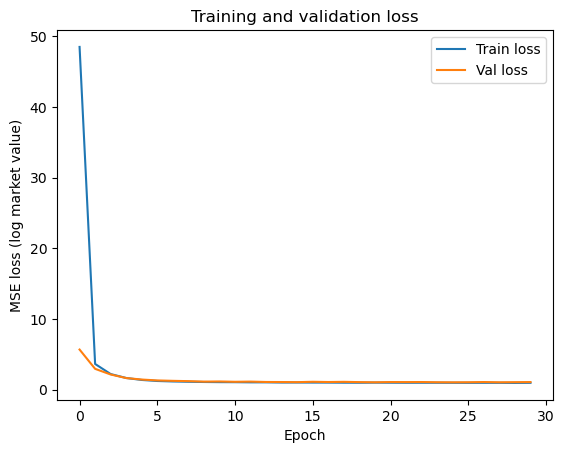

In [8]:
# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss (log market value)")
plt.legend()
plt.title("Training and validation loss")
plt.show()


In [9]:
# Save trained model weights
model_path = "player_value_mlp.pt"
torch.save(model.state_dict(), model_path)
model_path


'player_value_mlp.pt'